In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import torch
from utils.config import Config
from learner.dataset import FragmentDataset, DataCollator
from utils.parser import command_parser
from learner.model import Loss, Frag2Mol
import argparse
import pickle
from torch.utils.data import Dataset, DataLoader
import time
from gensim.models import Word2Vec
from collections import defaultdict

from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from learner.trainer import Trainer, save_ckpt
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/teddy_t/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Plot Latent Space

In [3]:
#config = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
#vocab = pickle.load(open('RUNS/2022-08-23@19:32:45-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
config = pickle.load(open('RUNS/2022-09-15@10:52:42-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-09-15@10:52:42-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 107611. Effective size: 107611. Time elapsed: 00:00:00.


In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [5]:
model

Frag2Mol(
  (embedder): Embedding(107611, 100)
  (latent2rnn): Linear(in_features=100, out_features=100, bias=True)
  (encoder): Encoder(
    (rnn): GRU(100, 100, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=200, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=200, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(100, 100, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=100, out_features=107611, bias=True)
  )
  (mlp): MLP(
    (layers_qed): Sequential(
      (0): Linear(in_features=100, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): ReLU()
      (4): Sigmoid()
    )
    (layers_logp): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=64, out_features=32, bias=True)
      (4): ReLU()
      (5): Dropout(

In [6]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
data_sample_correct = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103491. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
for idx, (src, tgt, lengths, data, tgt_str) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred_logp, pred_sas = model.forward(src, lengths)
    
    #print(torch.all(rnn2mean_weight == model.encoder.rnn2mean.weight))
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    #get correct id
    tgt_str_lst = [vocab.translate(target_i) for target_i in tgt.cpu().detach().numpy()]
    target_str_ls_2 = [" ".join(vocab.translate(target_i)) for target_i in tgt.cpu().detach().numpy()]
    src_str_ls_2 = [vocab.translate(target_i) for target_i in src.cpu().detach().numpy()]
    molecules = dataset.data.iloc[list(data)]
    data_index_correct = [molecules[molecules['fragments'] == target_str_ls_2_i].index.values[0] for target_str_ls_2_i in target_str_ls_2]
    molecules_correct = dataset.data.iloc[data_index_correct]
    data_sample_correct.append(data_index_correct)
            
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_logp_stack = pred_logp
        pred_sas_stack = pred_sas
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_logp_stack = torch.cat((pred_logp_stack, pred_logp), 0)
        pred_sas_stack = torch.cat((pred_sas_stack, pred_sas), 0)
    print(len(mu_stack))
    if len(mu_stack) > 90000:
        break

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [8]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [9]:
data_sample_index_correct = [item for sublist in data_sample_correct for item in sublist]

In [10]:
data_sample_index

[526,
 846,
 89029,
 4713,
 16808,
 39339,
 16143,
 85005,
 25565,
 100261,
 56569,
 56998,
 6230,
 2901,
 44127,
 72011,
 22469,
 76097,
 81470,
 29482,
 2657,
 49250,
 101033,
 99155,
 53370,
 70911,
 68170,
 63862,
 84844,
 70267,
 49994,
 33366,
 95971,
 43148,
 9312,
 83846,
 34117,
 53446,
 28924,
 67726,
 84423,
 84560,
 64480,
 75959,
 54366,
 87995,
 90856,
 82830,
 70264,
 79766,
 12351,
 55763,
 73913,
 82264,
 78348,
 48886,
 39089,
 79018,
 18522,
 47847,
 35799,
 34428,
 62117,
 40492,
 64726,
 48406,
 4505,
 65769,
 89137,
 96979,
 58287,
 58404,
 66038,
 39980,
 1025,
 90345,
 14608,
 23068,
 26385,
 91595,
 19625,
 73675,
 26290,
 83748,
 36137,
 31998,
 15213,
 23202,
 98435,
 72666,
 38294,
 47647,
 13797,
 20582,
 4735,
 24443,
 76250,
 36439,
 103074,
 66202,
 93830,
 50081,
 58449,
 7775,
 48163,
 66123,
 40293,
 6781,
 73934,
 58464,
 2042,
 7163,
 4082,
 14221,
 8434,
 14265,
 47588,
 21748,
 16396,
 60284,
 42217,
 30857,
 60323,
 79325,
 68681,
 12592,
 59720,

In [11]:
data_sample_index_correct

[72011,
 43148,
 1025,
 4713,
 25565,
 53370,
 33366,
 54366,
 82830,
 79766,
 18522,
 64726,
 48406,
 96979,
 58287,
 36137,
 15213,
 47647,
 20582,
 4735,
 66202,
 526,
 846,
 89029,
 16808,
 39339,
 16143,
 85005,
 100261,
 56569,
 56998,
 6230,
 2901,
 44127,
 22469,
 76097,
 81470,
 29482,
 2657,
 49250,
 101033,
 99155,
 70911,
 68170,
 63862,
 84844,
 70267,
 49994,
 95971,
 9312,
 83846,
 34117,
 53446,
 28924,
 67726,
 84423,
 84560,
 64480,
 75959,
 87995,
 90856,
 70264,
 12351,
 55763,
 73913,
 82264,
 78348,
 48886,
 39089,
 79018,
 47847,
 35799,
 34428,
 62117,
 40492,
 4505,
 65769,
 89137,
 58404,
 66038,
 39980,
 90345,
 14608,
 23068,
 26385,
 91595,
 19625,
 73675,
 26290,
 83748,
 31998,
 23202,
 98435,
 72666,
 38294,
 13797,
 24443,
 76250,
 36439,
 103074,
 91274,
 58449,
 66123,
 40293,
 6781,
 2042,
 4082,
 14265,
 42217,
 12592,
 90496,
 700,
 8576,
 86366,
 14636,
 55459,
 71187,
 24402,
 47794,
 17949,
 100187,
 93830,
 50081,
 7775,
 48163,
 73934,
 58464,

In [12]:
pred_sas_stack.cpu().detach().numpy()

array([2.8559175, 3.2738194, 3.0868735, ..., 2.613087 , 2.6850762,
       3.3765044], dtype=float32)

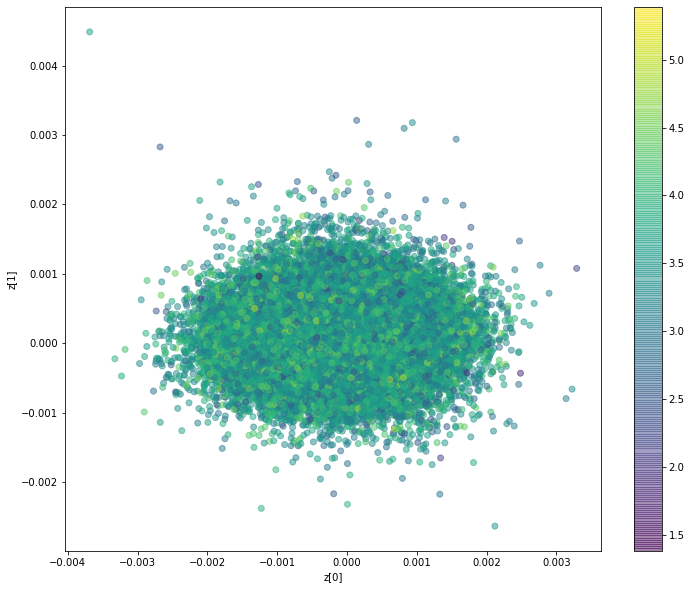

In [14]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_logp_stack.cpu().detach().numpy(), alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

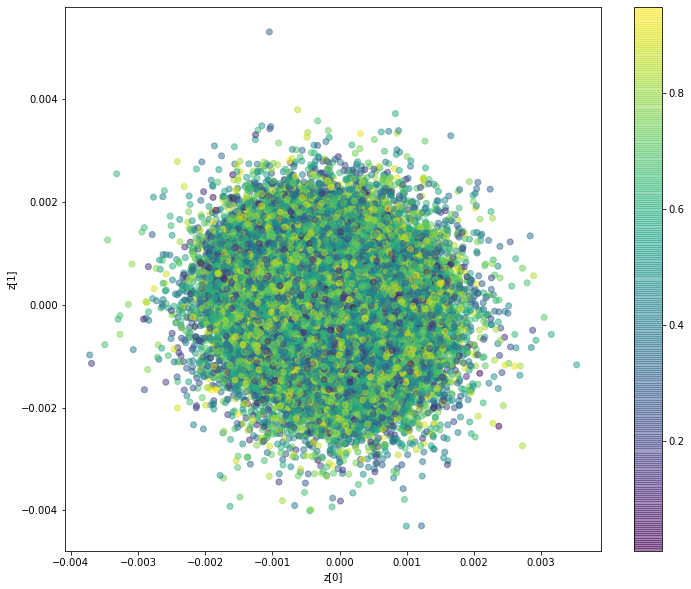

In [38]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=np.array(dataset.data.loc[data_sample_index_correct, 'qed']), alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [35]:
np.array(dataset.data.loc[data_sample_index_correct, 'qed'])

array([0.55360617, 0.09137225, 0.47602068, ..., 0.17678462, 0.3836151 ,
       0.88192645])

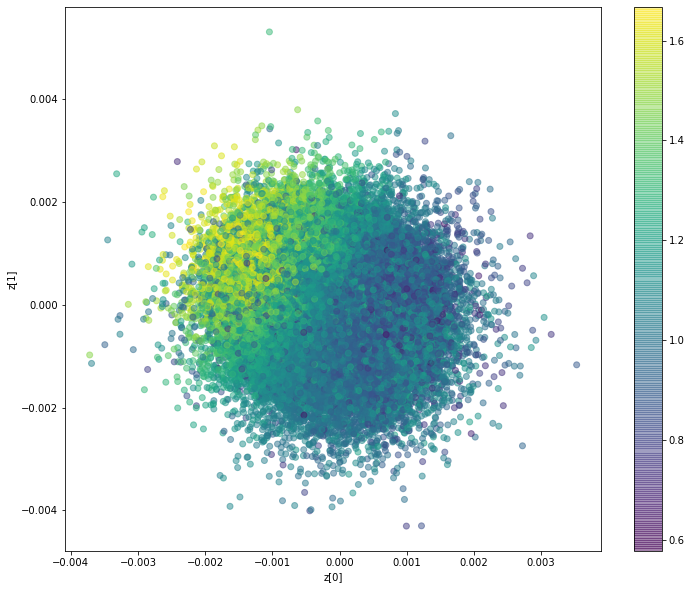

In [26]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=data_sample_index_correct.cpu().detach().numpy(), alpha=0.5)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [23]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [24]:
principalDf

,pc1,pc2
0,-0.219075,-0.217085
1,-0.471246,0.695805
2,-0.358805,1.091556
3,-0.099646,0.411897
4,0.001674,0.164199
...,...,...
90095,0.517028,-11.812552
90096,8.985769,-2.523432
90097,2.650877,-11.044983
90098,5.337794,5.196572


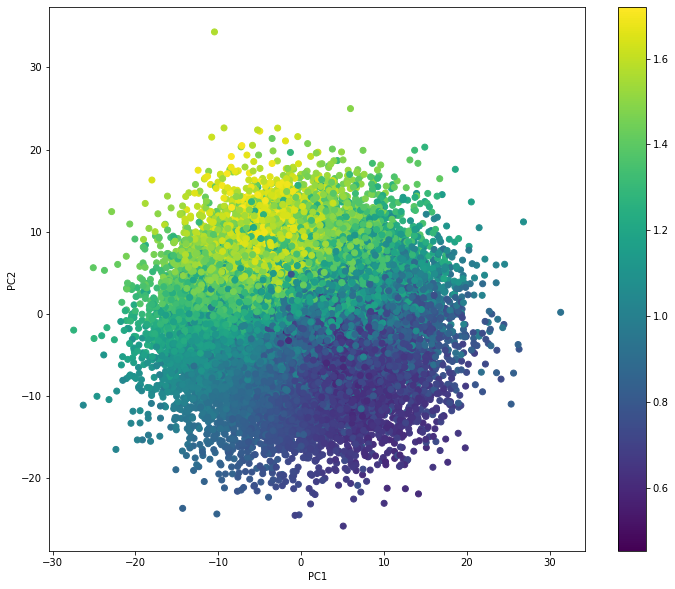

In [25]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_sas_stack.cpu().detach().numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

## Predict Property with XGBoost

In [58]:
mu_stack_norm_pd = pd.DataFrame(F.normalize(mu_stack).cpu().detach().numpy())

In [59]:
data.logP.values

array([0.9465, 3.0262, 1.0641, ..., 3.6773, 4.4523, 5.2173])

In [60]:
input_MLP_normalized_pd = pd.DataFrame(input_MLP_normalized)

In [61]:
model = XGBRegressor()
model.fit(mu_stack_norm_pd, data.logP.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [63]:
pred = model.predict(mu_stack_norm_pd)

In [64]:
rmse = np.sqrt(1/len(pred)*np.sum((data.logP.values - pred)**2))
print("RMSE : % f" %(rmse))

RMSE :  1.643491


In [65]:
pred

array([3.2425292, 3.730741 , 3.1778672, ..., 3.659052 , 3.676242 ,
       3.4999013], dtype=float32)

In [ ]:
plt.figure(figsize=(12, 10))
#plt.scatter( np.arange(len(pred)),np.array(pred))
plt.scatter( np.arange(len(pred)),np.array(data.logP.values))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Predict property with MLP

In [68]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [16]:
data = dataset.data.iloc[data_sample_index]

In [17]:
labels = torch.tensor(data.logP.values)

In [18]:
mu_stack.size()

torch.Size([100032, 100])

In [19]:
mu_stack_pd = pd.DataFrame(mu_stack.cpu().detach().numpy())

In [20]:
mu_stack_pd

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000033,0.000154,-0.000084,0.000126,-0.000100,-0.000059,0.000062,0.000059,-0.000056,-0.000160,...,0.000113,0.000071,-0.000060,-0.000059,-3.426522e-05,-0.000036,0.000129,-1.978129e-06,-0.000008,-0.000182
1,0.000029,0.000167,-0.000094,0.000128,-0.000114,-0.000069,0.000086,0.000047,-0.000061,-0.000172,...,0.000112,0.000089,-0.000084,-0.000067,-5.339831e-05,-0.000035,0.000124,-8.456409e-07,-0.000011,-0.000181
2,0.000029,0.000166,-0.000092,0.000128,-0.000108,-0.000066,0.000079,0.000048,-0.000060,-0.000179,...,0.000110,0.000080,-0.000076,-0.000072,-4.931539e-05,-0.000030,0.000131,-7.040799e-07,-0.000015,-0.000179
3,0.000031,0.000128,-0.000066,0.000127,-0.000125,-0.000073,0.000051,0.000081,-0.000033,-0.000154,...,0.000115,0.000094,-0.000061,-0.000099,-6.141514e-05,-0.000038,0.000138,-2.511963e-05,-0.000019,-0.000211
4,0.000065,0.000086,-0.000101,0.000201,-0.000080,0.000024,0.000115,0.000018,-0.000041,-0.000109,...,0.000051,0.000075,-0.000059,-0.000015,3.650784e-07,-0.000007,0.000160,6.873161e-06,-0.000061,-0.000150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100027,0.000052,0.000135,-0.000079,0.000132,-0.000084,-0.000031,0.000050,0.000049,-0.000063,-0.000158,...,0.000120,0.000067,-0.000069,-0.000051,-3.691763e-05,-0.000066,0.000095,2.450123e-05,0.000003,-0.000185
100028,0.000028,0.000129,-0.000107,0.000142,-0.000061,-0.000049,0.000051,0.000049,-0.000072,-0.000180,...,0.000139,0.000046,-0.000071,-0.000038,-4.427880e-05,-0.000032,0.000138,2.408400e-05,0.000016,-0.000164
100029,0.000028,0.000135,-0.000106,0.000150,-0.000115,-0.000039,0.000043,0.000073,-0.000038,-0.000154,...,0.000100,0.000092,-0.000062,-0.000071,-6.964058e-05,-0.000056,0.000108,-2.055988e-05,0.000021,-0.000186
100030,0.000029,0.000129,-0.000095,0.000149,-0.000081,-0.000040,0.000053,0.000042,-0.000046,-0.000156,...,0.000096,0.000050,-0.000060,-0.000043,-3.140420e-05,-0.000050,0.000106,1.634285e-05,0.000005,-0.000175


In [21]:
data

,smiles,fragments,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,logP,mr,qed,SAS
52738,C=C1C2C(NC(=O)C(N)c3ccccc3)C(=O)N2C(C(=O)O)=CC...,*C1C(=O)N2C(C(=O)O)=CC(C)(C)C(=C)C12 *NC(=O)C(...,3,19,0,3,4,0,20,8,0,0,1,0,2,0.94650,94.5749,0.549669,3.971813
93736,CS(=O)(=O)C1(c2cc(N3CC4CCC(C3)O4)nc(-c3cccc4[n...,*C1(S(C)(=O)=O)CC1 *c1cc(N2CC3CCC(C2)O3)nc(-c2...,2,22,0,4,3,1,26,9,0,1,0,2,3,3.02620,115.1885,0.692663,4.456667
23167,CC(C)CN(CC(C)C)C(=O)N1CC(N)C(C(=O)O)C1,*CC(C)C *N(*)CC(C)C *C(=O)N1CC(N)C(C(=O)O)C1,3,14,0,3,3,0,18,2,0,0,0,1,0,1.06410,77.3192,0.790590,3.382639
24621,COc1ccc(Cc2ccc(OC3OCC(O)C(O)C3O)cc2)cc1,*c1ccc(OC)cc1 *Cc1ccc(OC2OCC(O)C(O)C2O)cc1,2,19,0,0,6,0,21,6,0,0,0,0,3,1.10380,90.6304,0.751506,3.151427
8983,Cc1ccsc1C=NNC(=O)c1nnn(-c2nonc2N)c1-c1ccccc1,*C(=O)NN=Cc1sccc1C *c1nnn(-c2nonc2N)c1-c1ccccc1,2,17,0,8,2,1,20,11,0,0,0,3,1,2.03332,103.1796,0.390111,2.748864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48999,O=C1NCCCc2[nH]c3c(ccc4cnc(-c5cncc(OCCN6CCOCC6)...,*c1cc2c(ccc3c4c([nH]c32)CCCNC4=O)cn1 *c1cncc(O...,2,26,0,5,3,0,29,10,0,0,0,1,4,3.16510,130.2389,0.478360,2.960355
7596,COc1cc2c(=O)c(C(=O)c3ccc(C)cc3)cn(CC3CC3)c2cc1OC,*c1cn(CC2CC2)c2cc(OC)c(OC)cc2c1=O *C(=O)c1ccc(...,2,23,0,1,4,0,22,9,0,1,0,0,3,3.96812,108.6475,0.610157,2.208684
51076,NC(=O)c1cccc(C2CC3CCC(C2)N3CCN(CC2CCCCC2)C(=O)...,*C(N)=O *c1cccc(C2CC3CCC(C2)N3CCN(CC2CCCCC2)C(...,2,27,0,3,3,0,31,5,0,0,0,1,3,3.67730,129.9257,0.563468,4.088032
39999,O=C(OCc1ccccc1)N1CCN(C(=S)SCc2cn(Cc3ccc(Cl)cc3...,*C(=O)N1CCN(C(=S)SCc2cn(Cc3ccc(Cl)cc3)nn2)CC1 ...,2,23,0,5,2,3,26,10,0,0,0,1,3,4.45230,134.2420,0.462128,2.495275


In [22]:
data.drop(['smiles', 'fragments', 'logP'], axis = 1)

,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,mr,qed,SAS
52738,3,19,0,3,4,0,20,8,0,0,1,0,2,94.5749,0.549669,3.971813
93736,2,22,0,4,3,1,26,9,0,1,0,2,3,115.1885,0.692663,4.456667
23167,3,14,0,3,3,0,18,2,0,0,0,1,0,77.3192,0.790590,3.382639
24621,2,19,0,0,6,0,21,6,0,0,0,0,3,90.6304,0.751506,3.151427
8983,2,17,0,8,2,1,20,11,0,0,0,3,1,103.1796,0.390111,2.748864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48999,2,26,0,5,3,0,29,10,0,0,0,1,4,130.2389,0.478360,2.960355
7596,2,23,0,1,4,0,22,9,0,1,0,0,3,108.6475,0.610157,2.208684
51076,2,27,0,3,3,0,31,5,0,0,0,1,3,129.9257,0.563468,4.088032
39999,2,23,0,5,2,3,26,10,0,0,0,1,3,134.2420,0.462128,2.495275


In [23]:
input_MLP = torch.tensor(mu_stack_pd.join(data.drop(['smiles', 'fragments', 'logP'], axis = 1)).values).float()

In [24]:
input_MLP_normalized = F.normalize(input_MLP).float()

In [25]:
input_MLP_normalized.size()

torch.Size([100032, 116])

In [75]:
MLP_model = MLP()

In [76]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [77]:
latent_output_data

tensor([[ 3.2544e-05,  1.5355e-04, -8.3797e-05,  ..., -1.9781e-06,
         -8.0653e-06, -1.8182e-04],
        [ 2.9415e-05,  1.6726e-04, -9.3691e-05,  ..., -8.4564e-07,
         -1.1105e-05, -1.8102e-04],
        [ 2.8998e-05,  1.6571e-04, -9.1933e-05,  ..., -7.0408e-07,
         -1.4786e-05, -1.7908e-04],
        ...,
        [ 2.7627e-05,  1.3538e-04, -1.0615e-04,  ..., -2.0560e-05,
          2.0657e-05, -1.8607e-04],
        [ 2.8700e-05,  1.2900e-04, -9.4824e-05,  ...,  1.6343e-05,
          4.9062e-06, -1.7495e-04],
        [ 1.4454e-05,  1.5057e-04, -9.9771e-05,  ...,  6.9179e-06,
          8.5644e-06, -1.6421e-04]], device='cuda:0', grad_fn=<CatBackward0>)

In [78]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    MLP_model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-78-6c563c019837>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : 3.3188
epoch : 2, train loss : 3.2972
epoch : 3, train loss : 3.2861
epoch : 4, train loss : 3.2792
epoch : 5, train loss : 3.2782
epoch : 6, train loss : 3.2779
epoch : 7, train loss : 3.2774
epoch : 8, train loss : 3.2772
epoch : 9, train loss : 3.2769
epoch : 10, train loss : 3.2767
epoch : 11, train loss : 3.2762
epoch : 12, train loss : 3.2759
epoch : 13, train loss : 3.2757
epoch : 14, train loss : 3.2752
epoch : 15, train loss : 3.2744
epoch : 16, train loss : 3.2741
epoch : 17, train loss : 3.2740
epoch : 18, train loss : 3.2739
epoch : 19, train loss : 3.2738
epoch : 20, train loss : 3.2736


In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

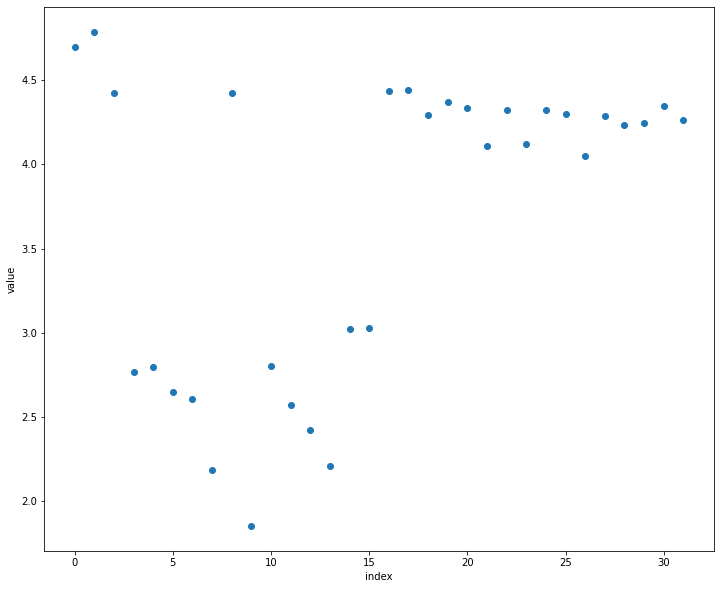

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Plot Embedding Space

In [6]:
vocab.w2i

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 'cluster_4': 3,
 'cluster_5': 4,
 'cluster_3': 5,
 'cluster_6': 6,
 'cluster_2': 7,
 'cluster_7': 8,
 '*OCC': 9,
 'cluster_1': 10,
 '*c1ccccc1': 11,
 '*c1ccc(OC)cc1': 12,
 '*C(C)=O': 13,
 '*C(C)C': 14,
 '*CCC': 15,
 '*N(C)C': 16,
 '*c1ccc(C)cc1': 17,
 '*C(=O)O': 18,
 '*C(=O)OC': 19,
 '*CCCC': 20,
 'cluster_0': 21,
 '*C(C)(C)C': 22,
 '*c1ccccc1OC': 23,
 '*Cc1ccccc1': 24,
 '*c1cccc(OC)c1': 25,
 '*N(CC)CC': 26,
 '*c1ccc(OC)c(OC)c1': 27,
 '*C(F)(F)F': 28,
 'cluster_m1': 29,
 '*C(N)=O': 30,
 '*CC=C': 31,
 '*c1ccccc1C': 32,
 '*CCOC': 33,
 '*c1cccc(C)c1': 34,
 '*c1ccc(Cl)cc1': 35,
 '*CC(C)C': 36,
 '*c1ccc(F)cc1': 37,
 '*CC(=O)O': 38,
 '*CCN*': 39,
 '*N1CCN(C)CC1': 40,
 '*c1cc(OC)c(OC)c(OC)c1': 41,
 '*NCC': 42,
 '*NC(*)=O': 43,
 '*S(C)(=O)=O': 44,
 '*C(=O)NC': 45,
 '*N1CCOCC1': 46,
 '*CCCCC': 47,
 '*C(=O)CC': 48,
 'cluster_m2': 49,
 '*C(=O)c1ccccc1': 50,
 '*=C(C)C': 51,
 '*S(=O)(=O)c1ccc(C)cc1': 52,
 '*CCCCCC': 53,
 '*Nc1ccccc1': 54,
 '*c1ccco1': 55,
 '*

In [7]:
df_vocab_i2w = pd.DataFrame.from_dict(vocab.i2w, orient='index')
df_vocab_i2w = df_vocab_i2w.rename(columns = {0: 'fragment'}) 
df_vocab_i2w['sum_log_p'] = 0
df_vocab_i2w['count_log_p'] = 0

In [8]:
vocab.w2w_infreq

{'*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 'cluster_3',
 '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 'cluster_5',
 '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 'cluster_7',
 '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 'cluster_4',
 '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 'cluster_3',
 '*c1cccc(-c2ccc(C#N)cc2)c1': 'cluster_6',
 '*CC1(OC)OOC(*)(C)CC1CO': 'cluster_4',
 '*Nc1ccc2c3c(cccc13)C(=O)N(CCCN1CCCNCCNCCCNCC1)C2=O': 'cluster_5',
 '*N1C2CCC1C(C(=O)OC)=C(c1cc3ccccc3o1)C2': 'cluster_5',
 '*=Cc1cccc(C(F)(F)P(=O)(O)O)c1': 'cluster_4',
 '*c1cc(N)nc(NC2CCCC2)c1': 'cluster_3',
 '*N(CC)c1ccc(OC)c2nc(NC(=O)C3CCN(C(=O)c4cccc(C(F)(F)F)c4)CC3)sc12': 'cluster_6',
 '*C1CCC(C)C(c2ccc(C)cc2)N1C(=O)c1ccc(C=NOCC(O)COCc2ccco2)cc1': 'cluster_5',
 '*C(=O)C1(Cc2ccccc2C)CCCN(C(=O)CCC(=O)OC)C1': 'cluster_3',
 '*n1c(CN2C(=O)COc3c2cc(C)cc3[N+](=O)[O-])nnc1-c1ccc(Cl)cn1': 'cluster_4',
 '*NC(=O)c1cc(-c2cccc(F)c2)ccn1': 'cluster_4',
 '*c1cccnc1C1CC(O)C(NC(=N)N)CC1NC(=N)N'

In [9]:
df_vocab_w2w_infreq = pd.DataFrame.from_dict(vocab.w2w_infreq, orient='index').reset_index()
df_vocab_w2w_infreq = df_vocab_w2w_infreq.rename(columns = {'index': 'fragment', 0: 'cluster'}) 

In [10]:
fragment_statistics = []

In [11]:
for i in tqdm(range(len(dataset.data))):
    fragments = dataset.data.fragments[i]
    fragment_log_p = dataset.data.logP[i]
    frag_list = fragments.split()
    for frag in frag_list:
        fragment_statistics.append([frag, fragment_log_p])

100%|██████████| 103491/103491 [00:02<00:00, 49761.33it/s]


In [12]:
df_fragment_statistics = pd.DataFrame(fragment_statistics, columns=["Fragment", "LogP"])

In [13]:
vocab.w2w_infreq["*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O"]

'cluster_3'

In [14]:
for infreq_frag in tqdm(vocab.w2w_infreq):
    df_fragment_statistics.loc[df_fragment_statistics['Fragment'] == infreq_frag, "cluster"] = vocab.w2w_infreq[infreq_frag]

100%|██████████| 99630/99630 [22:21<00:00, 74.27it/s]


In [15]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster_3
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster_5
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster_3
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


Mean LogP for cluster_1: 0.58


<AxesSubplot:>

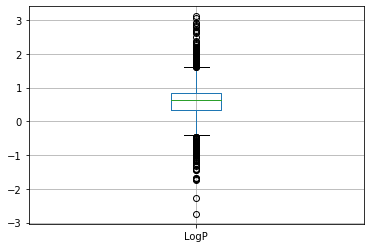

In [18]:
print("Mean LogP for cluster_1: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_1'].boxplot(column=['LogP']) 

Mean LogP for cluster_2: 1.57


<AxesSubplot:>

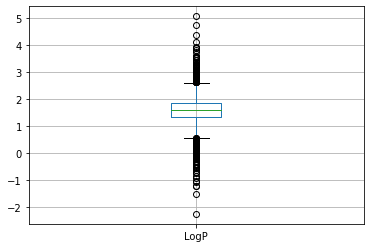

In [19]:
print("Mean LogP for cluster_2: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_2'].boxplot(column=['LogP']) 

Mean LogP for cluster_m5: -5.42


<AxesSubplot:>

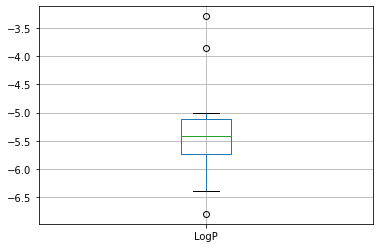

In [22]:
print("Mean LogP for cluster_m5: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_m5'].boxplot(column=['LogP']) 

Mean LogP for cluster 6: 5.44


<AxesSubplot:>

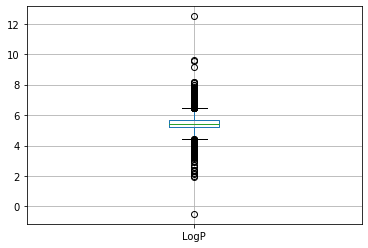

In [24]:
print("Mean LogP for cluster 6: %.2f" % np.mean(df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].LogP))
df_fragment_statistics[df_fragment_statistics['cluster']=='cluster_6'].boxplot(column=['LogP']) 

In [20]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster1_1
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster1_1
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster1_1
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


In [21]:
df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']

0         0.496781
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
107603    0.289631
107604    1.495876
107605    1.404381
107606    0.059185
107607         NaN
Name: LogP, Length: 107608, dtype: float64

In [22]:
df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

0          5
1          1
2          1
3          1
4          1
          ..
107603     2
107604    12
107605     8
107606     2
107607     1
Name: 0, Length: 107608, dtype: int64

In [23]:
df_fragment_statistics_unique = df_fragment_statistics.groupby('Fragment').mean().reset_index()

In [24]:
df_fragment_statistics_unique['LogP_std'] = df_fragment_statistics.groupby('Fragment').std().reset_index()['LogP']
df_fragment_statistics_unique['frequency'] = df_fragment_statistics.groupby('Fragment').size().reset_index()[0]

In [25]:
df_fragment_statistics_unique

,Fragment,LogP,LogP_std,frequency
0,*#CC(C)(C)C,5.379280,0.496781,5
1,*#CC1(C(F)(F)F)CCC1,6.163200,NaN,1
2,*#CC1CCC(CNCC(F)(F)F)N1,6.430400,NaN,1
3,*#CC=CC(O)COc1ccc(F)cc1,1.060400,NaN,1
4,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.954000,NaN,1
...,...,...,...,...
107603,*n1sc2cc(F)ccc2c1=O,3.045600,0.289631,2
107604,*n1sc2ccccc2c1=O,3.773668,1.495876,12
107605,*n1sc2nc(C)cc(C)c2c1=O,2.258250,1.404381,8
107606,*n1sc2ncccc2c1=O,2.506250,0.059185,2


In [26]:
df_fragment_statistics_unique_infreq = df_fragment_statistics_unique[df_fragment_statistics_unique['frequency']<=2].reset_index(drop = True)

array([[<AxesSubplot:title={'center':'LogP'}>,
        <AxesSubplot:title={'center':'LogP_std'}>],
       [<AxesSubplot:title={'center':'frequency'}>, <AxesSubplot:>]],
      dtype=object)

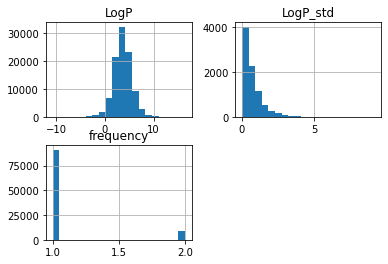

In [27]:
df_fragment_statistics_unique_infreq.hist(bins = 20)

In [28]:
len(df_fragment_statistics_unique_infreq[(df_fragment_statistics_unique_infreq['LogP']>=9) & (df_fragment_statistics_unique_infreq['LogP']<10)])

329

In [36]:
df_fragment_statistics_unique_infreq['cluster'] = ''

In [37]:
df_fragment_statistics_unique_infreq

,Fragment,LogP,LogP_std,frequency,cluster
0,*#CC1(C(F)(F)F)CCC1,6.16320,NaN,1,
1,*#CC1CCC(CNCC(F)(F)F)N1,6.43040,NaN,1,
2,*#CC=CC(O)COc1ccc(F)cc1,1.06040,NaN,1,
3,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.95400,NaN,1,
4,*#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,5.81310,NaN,1,
...,...,...,...,...,...
99625,*n1sc(=O)n(Cc2ccccc2)c1=O,1.52225,0.010677,2,
99626,*n1sc(N)c(C(=O)OCC)c1=S,2.22399,NaN,1,
99627,*n1sc2cc(F)ccc2c1=O,3.04560,0.289631,2,
99628,*n1sc2ncccc2c1=O,2.50625,0.059185,2,


In [38]:
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] < -6), 'cluster'] = 'cluster_m6'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -6) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -5), 'cluster'] = 'cluster_m5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -4), 'cluster'] = 'cluster_m4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -3), 'cluster'] = 'cluster_m3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -2), 'cluster'] = 'cluster_m2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < -1), 'cluster'] = 'cluster_m1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= -1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 0), 'cluster'] = 'cluster_0'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 0) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 1), 'cluster'] = 'cluster_1'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 1) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 2), 'cluster'] = 'cluster_2'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 2) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 3), 'cluster'] = 'cluster_3'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 3) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 4), 'cluster'] = 'cluster_4'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 4) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 5), 'cluster'] = 'cluster_5'
df_fragment_statistics_unique_infreq.loc[(df_fragment_statistics_unique_infreq['LogP'] >= 5) 
                                         & (df_fragment_statistics_unique_infreq['LogP'] < 6), 'cluster'] = 'cluster_6'
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['LogP'] >= 6, 'cluster'] = 'cluster_7'

In [59]:
df_fragment_statistics_unique_infreq

,Fragment,LogP,LogP_std,frequency,cluster
0,*#CC1(C(F)(F)F)CCC1,6.16320,NaN,1,cluster_7
1,*#CC1CCC(CNCC(F)(F)F)N1,6.43040,NaN,1,cluster_7
2,*#CC=CC(O)COc1ccc(F)cc1,1.06040,NaN,1,cluster_2
3,*#CCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,6.95400,NaN,1,cluster_7
4,*#CCCCCC#CCS(=O)(=O)c1ccc2ccccc2c1,5.81310,NaN,1,cluster_6
...,...,...,...,...,...
99625,*n1sc(=O)n(Cc2ccccc2)c1=O,1.52225,0.010677,2,cluster_2
99626,*n1sc(N)c(C(=O)OCC)c1=S,2.22399,NaN,1,cluster_3
99627,*n1sc2cc(F)ccc2c1=O,3.04560,0.289631,2,cluster_4
99628,*n1sc2ncccc2c1=O,2.50625,0.059185,2,cluster_3


In [61]:
df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == '*#CC1(C(F)(F)F)CCC1', 'cluster'][0]

'cluster_7'

In [45]:
df_fragment_statistics_unique_cluster = pd.concat([df_fragment_statistics_unique[df_fragment_statistics_unique['frequency'] > 2], df_fragment_statistics_unique_infreq])

In [46]:
df_fragment_statistics

,Fragment,LogP,cluster
0,*CCC,2.33400,NaN
1,*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(...,2.33400,cluster1_1
2,*c1ccc(O)cc1,4.94030,NaN
3,*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1,4.94030,cluster1_1
4,*C(=O)OC,6.07540,NaN
...,...,...,...
231861,*CN1C(=O)NC2(CCCC2)C1=O,1.39340,NaN
231862,*C(=O)N1CCN(c2cccnn2)CC1,2.72930,cluster1_1
231863,*Nc1ccc(OC(F)(F)F)cc1,2.72930,NaN
231864,*c1cc(F)ccc1C,5.59412,NaN


In [53]:
def calculate_frequencies(sentences):
    w2f = defaultdict(int)

    for sentence in sentences:
        for word in sentence:
            w2f[word] += 1

    return w2f

In [79]:
SOS_TOKEN = '<SOS>'
PAD_TOKEN = '<PAD>'
EOS_TOKEN = '<EOS>'
TOKENS = [SOS_TOKEN, PAD_TOKEN, EOS_TOKEN]
start = time.time()
print("Training and clustering embeddings...", end=" ")

embed_size = config.get('embed_size')
embed_window = config.get('embed_window')
mask_freq = config.get('mask_freq')
use_mask = config.get('use_mask')

i2w_infreq = None
w2w_infreq = None
c2w_infreq = None
start_idx = len(TOKENS)

if use_mask:
    sentences = [s.split(" ") for s in df_fragment_statistics.Fragment]
    # first word embedding
    w2v = Word2Vec(
        sentences,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

    vocab = w2v.wv.key_to_index
    embeddings = w2v.wv[vocab]

    w2f = calculate_frequencies(sentences)
    w2i = {k: v for (k, v) in vocab.items()}
    i2w = {v: k for (k, v) in w2i.items()}

    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in tqdm(infreq):
        word = i2w[inf]
        i2w_infreq[inf] = df_fragment_statistics_unique_infreq.loc[df_fragment_statistics_unique_infreq['Fragment'] == word, 'cluster'].values[0]
        
end = time.time() - start
elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
print(f'Done. Time elapsed: {elapsed}.')

Training and clustering embeddings... 

100%|██████████| 99630/99630 [23:27<00:00, 70.79it/s]

Done. Time elapsed: 00:23:32.


In [80]:
w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
c2w_infreq = defaultdict(list)
for word, cluster_name in w2w_infreq.items():
    c2w_infreq[cluster_name].append(word)

# substitute infrequent words with cluster words
data = []
for sentence in sentences:
    sentence_sub = []
    for word in sentence:
        if word in w2w_infreq:
            word = w2w_infreq[word]
        sentence_sub.append(word)
    data.append(sentence_sub)

In [82]:
w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}_2.dat'
np.savetxt(path, embeddings, delimiter=",")

In [57]:
w2f

defaultdict(int,
            {'*CCC': 1949,
             '*N(CCc1cccc(-c2ccccc2)c1)C(=O)C1OC(C(=O)O)=CC(N)C1NC(C)=O': 1,
             '*c1ccc(O)cc1': 258,
             '*C1CC(c2ccccc2)=NN1C(=S)Nc1ccccc1': 1,
             '*C(=O)OC': 1550,
             '*CCCC=C(c1cc(*)c(OC)c(Cl)c1)c1cc(Cl)c(OC)c(C(=O)OC)c1': 1,
             '*C(=O)SC': 5,
             '*c1cc(C)nc2ccccc12': 58,
             '*COc1ccc(NC(=O)C2CN(C)CCC2C(=O)NO)cc1': 1,
             '*OCC': 4930,
             '*C(=O)c1ccc(O)c(-n2cc3c(c2-c2ccccc2)c(=O)n(C)c(=O)n3C)c1': 1,
             '*c1cc(=O)oc2cc(OC)cc(OC)c12': 4,
             '*c1cccc(-c2ccc(C#N)cc2)c1': 1,
             '*c1cc2c(OC)c(OC)c(OC)cc2[nH]1': 5,
             '*C(=O)Nc1ccc(F)cc1': 16,
             '*c1cc(F)cc(OC)c1': 5,
             '*C(=O)NC(CC(=O)O)c1ccc(*)cc1': 3,
             '*C1CCCN1S(=O)(=O)c1cc(Cl)cc(Cl)c1': 3,
             '*c1ccc(Cl)c(OC)c1': 9,
             '*c1cc(OC)c(-n2c(=O)ccc3cc(S(=O)(=O)Nc4cccnn4)ccc32)cc1F': 4,
             '*CCCC': 1479,
    

In [ ]:
    infreq = [w2i[w] for (w, freq) in w2f.items() if freq <= mask_freq]            
    i2w_infreq = {}
    for inf in infreq:
        word = i2w[inf]
        i2w_infreq[inf] = f"cluster{w2f[word]}_{word.count('*')}"

    w2w_infreq = {i2w[k]: v for (k, v) in i2w_infreq.items()}
    c2w_infreq = defaultdict(list)
    for word, cluster_name in w2w_infreq.items():
        c2w_infreq[cluster_name].append(word)

    # substitute infrequent words with cluster words
    data = []
    for sentence in sentences:
        sentence_sub = []
        for word in sentence:
            if word in w2w_infreq:
                word = w2w_infreq[word]
            sentence_sub.append(word)
        data.append(sentence_sub)
else:
    data = [s.split(" ") for s in data.fragments]

w2i = {PAD_TOKEN: 0, SOS_TOKEN: 1, EOS_TOKEN: 2}

w2v = Word2Vec(
        data,
        vector_size=embed_size,
        window=embed_window,
        min_count=1,
        negative=5,
        workers=20,
        epochs=10,
        sg=1)

vocab = w2v.wv.key_to_index
w2i.update({k: v + start_idx for (k, v) in vocab.items()})
i2w = {v: k for (k, v) in w2i.items()}

tokens = np.random.uniform(-0.05, 0.05, size=(start_idx, embed_size))
embeddings = np.vstack([tokens, w2v.wv[vocab]])
path = config.path('config') / f'emb_{embed_size}.dat'
np.savetxt(path, embeddings, delimiter=",")

In [88]:
df_fragment_statistics_unique_infreq.to_csv('DATA/CHEMBL/PROCESSED/df_fragment_statistics_unique_infreq.smi', index=False)

In [5]:
vocab.i2w

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: 'cluster_4',
 4: 'cluster_5',
 5: 'cluster_3',
 6: 'cluster_6',
 7: 'cluster_2',
 8: 'cluster_7',
 9: '*OCC',
 10: 'cluster_1',
 11: '*c1ccccc1',
 12: '*c1ccc(OC)cc1',
 13: '*C(C)=O',
 14: '*C(C)C',
 15: '*CCC',
 16: '*N(C)C',
 17: '*c1ccc(C)cc1',
 18: '*C(=O)O',
 19: '*C(=O)OC',
 20: '*CCCC',
 21: 'cluster_0',
 22: '*C(C)(C)C',
 23: '*c1ccccc1OC',
 24: '*Cc1ccccc1',
 25: '*c1cccc(OC)c1',
 26: '*N(CC)CC',
 27: '*c1ccc(OC)c(OC)c1',
 28: '*C(F)(F)F',
 29: 'cluster_m1',
 30: '*C(N)=O',
 31: '*CC=C',
 32: '*c1ccccc1C',
 33: '*CCOC',
 34: '*c1cccc(C)c1',
 35: '*c1ccc(Cl)cc1',
 36: '*CC(C)C',
 37: '*c1ccc(F)cc1',
 38: '*CC(=O)O',
 39: '*CCN*',
 40: '*N1CCN(C)CC1',
 41: '*c1cc(OC)c(OC)c(OC)c1',
 42: '*NCC',
 43: '*NC(*)=O',
 44: '*S(C)(=O)=O',
 45: '*C(=O)NC',
 46: '*N1CCOCC1',
 47: '*CCCCC',
 48: '*C(=O)CC',
 49: 'cluster_m2',
 50: '*C(=O)c1ccccc1',
 51: '*=C(C)C',
 52: '*S(=O)(=O)c1ccc(C)cc1',
 53: '*CCCCCC',
 54: '*Nc1ccccc1',
 55: '*c1ccco1',
 56

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler


In [34]:
dataset = FragmentDataset(config)
fragment_list = []
for frag in tqdm(dataset.data.fragments):
    fragment_list.extend(frag.split())
fragment_counts = pd.Series(fragment_list).value_counts()
fragment_counts = fragment_counts.append(pd.Series(len(dataset.data)))

100%|██████████| 103491/103491 [00:00<00:00, 1550143.44it/s]
<ipython-input-34-d36c8fdc66ac>:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fragment_counts = fragment_counts.append(pd.Series(len(dataset.data)))


In [35]:
penalty = np.sum(np.log(fragment_counts + 1))/np.log(fragment_counts + 1)
penalty_weights = penalty/np.linalg.norm(penalty)

In [36]:
penalty_weights

*OCC                                          0.000263
*c1ccccc1                                     0.000276
*c1ccc(OC)cc1                                 0.000279
*C(C)=O                                       0.000280
*C(C)C                                        0.000291
                                                ...   
*c1ccc(NC(=O)Nc2nccs2)cc1                     0.003231
*C(=O)c1cc(Cl)nn1-c1ncccc1Cl                  0.003231
*NC(=S)Nc1c(*)cc(Cl)cc1C                      0.003231
*C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1    0.003231
0                                             0.000194
Length: 107609, dtype: float64

In [26]:
penalty_weights

*OCC                                          0.000263
*c1ccccc1                                     0.000276
*c1ccc(OC)cc1                                 0.000279
*C(C)=O                                       0.000280
*C(C)C                                        0.000291
                                                ...   
*c1ccc(NC(=O)Nc2nccs2)cc1                     0.003231
*C(=O)c1cc(Cl)nn1-c1ncccc1Cl                  0.003231
*NC(=S)Nc1c(*)cc(Cl)cc1C                      0.003231
*C(=O)Nc1ccc(C(=O)N2Cc3sccc3Cc3ccccc32)cn1    0.003231
0                                             0.000194
Length: 107609, dtype: float64

In [16]:
min_max_scaler.fit_transform(penalty_weights.values.reshape(-1, 1)).size

107608

In [13]:
test_df = pd.DataFrame(fragment_counts, columns=['count'])

In [9]:
test = (['<SOS>', '*c1c2n(cc(OC)c1=O)-c1c(ccnc1CC(C)C)C2=O', '*C(C)C', '<EOS>'], ['<SOS>', '*c1cc(=O)n(C)c(=O)n1C', '*CNC(*)=O', '*CNC(=O)C*', '*c1ccccc1', '<EOS>'], ['<SOS>', '*C(C)c1nnc(SCC(=O)c2cc3ccccc3oc2=O)o1', '*c1ccc(-c2ccccc2)c(F)c1', '<EOS>'], ['<SOS>', '*=C(C)CO', '*c1cc2oc(C)cc(=O)c2c(O)c1CC=*', '*OC1OC(CO)C(O)C(O)C1O', '<EOS>'], ['<SOS>', '*=C1SC(=O)N(Cc2ccc(F)cc2)C1=O', '*=Cc1c2ccccc2nc2ccccc12', '<EOS>'], ['<SOS>', '*C(=O)CC', '*NC1CCCc2c(-c3cc(F)c(F)cc3F)cncc21', '<EOS>'], ['<SOS>', '*OCC', '*NC(=O)c1ccc(*)cc1', '*c1ccccc1C(=O)O', '<EOS>'], ['<SOS>', '*NC(=N)N', '*CCCC(NC(=O)C(*)NC(=O)C(Cc1ccc(Cl)cc1)NC(=O)CO)C(=O)NC(Cc1c[nH]c2ccccc12)C(N)=O', '*Cc1ccccc1', '<EOS>'], ['<SOS>', '*C(=O)c1cc(-c2ccccn2)nc2ccccc12', '*NC1CC1', '<EOS>'], ['<SOS>', '*C(=O)CC(NN=C(N)c1ccccn1)c1ccc(Br)cc1', '*c1ccc(-n2ccnc2)cc1', '<EOS>'], ['<SOS>', '*OCC', '*CCCN1CC(*)CC1=O', '*C(=O)NCc1ccc2c(c1)OCO2', '<EOS>'], ['<SOS>', '*c1ccc2c(c1C)COC2=O', '*C(O)CN1CC2CCC(C1)N2S(=O)(=O)c1ccc(-n2cnnn2)cc1', '<EOS>'], ['<SOS>', '*c1nc(C2CC2)nc(N2CCC(C)(C)CC2)c1C', '*NC1CC1', '<EOS>'], ['<SOS>', '*c1cc(OC)ccc1Cl', '*Nc1ncnc2cc(OC)cc(OC3CCN(C)CC3)c12', '<EOS>'], ['<SOS>', '*C(C)N1C(=O)OC(Cc2ccccc2)(C(=O)NCc2ccc(Cl)cc2)C1=O', '*c1ccccc1', '<EOS>'], ['<SOS>', '*C(=O)N(CC=Cc1ccccc1)CC1CC(F)CN1', '*c1ccc(-c2cnc3ccc(NCC4CC4)nn23)cc1', '<EOS>'], ['<SOS>', '*c1ccc(OC)cc1', '*C(=O)C=CNNC(=O)c1ccc(Cl)cc1', '<EOS>'], ['<SOS>', '*OCC', '*C(=O)c1cccc(O)c1O', '<EOS>'], ['<SOS>', '*C1CCN(C)CC1', '*c1ccc(Nc2nc(-c3cc(F)cc(N4CCn5c(cc6c5CCCC6)C4=O)c3CO)cn(C)c2=O)cc1', '<EOS>'], ['<SOS>', '*c1cccc(C)c1', '*CNc1ccc(S(=O)(=O)N2CCCCC2)cc1', '<EOS>'], ['<SOS>', '*c1cccc(OC)c1', '*C(C)Nc1cc(-c2ccc3sccc3c2)nc(C)n1', '<EOS>'], ['<SOS>', '*C(C)=O', '*c1c(C(C)=O)c(C)n(-c2ccc(C(=O)O)cc2)c1C', '<EOS>'], ['<SOS>', '*C(=O)N1CCC2(CC1)OCCO2', '*c1cc2ccccn2n1', '<EOS>'], ['<SOS>', '*OCC', '*C(=O)CSc1ccc(-c2nc(C)no2)cn1', '<EOS>'], ['<SOS>', '*=CC(=O)c1cc(Cl)c[nH]1', '*=Cc1ccccc1O', '<EOS>'], ['<SOS>', '*C1(Cc2ccccc2)C(=O)Nc2ccc(F)cc2C1O', '*Cc1ccccc1', '<EOS>'], ['<SOS>', '*c1nc2cc(C(C)=NNC(N)=S)ccc2n1C1CCCCC1', '*c1ccoc1', '<EOS>'], ['<SOS>', '*CC(=O)Nc1ccc(Br)cc1', '*SSCC(*)=O', '*Nc1ccc(Br)cc1', '<EOS>'], ['<SOS>', '*c1ccc(OC)c(OC)c1', '*c1cc(C(=O)Nc2ccccc2O)c2ccccc2n1', '<EOS>'], ['<SOS>', '*C(C)=O', '*NC1C(O)CC(Oc2ccc(-n3cc(COC(=O)Nc4ccccc4[N+](=O)[O-])nn3)cc2C(F)F)(C(=O)O)OC1C(O)C(O)CO', '<EOS>'], ['<SOS>', '*n1cnc(C)c1', '*c1ccc2n(c1=O)CCN(CC1CC(F)C(c3ccc(C(F)(F)F)cc3)O1)C2=O', '<EOS>'], ['<SOS>', '*c1ccc2nc3n(C)c4ccccc4c(C)c-3c2c1', '*NC(=O)C(N)Cc1cnc[nH]1', '<EOS>'])

In [21]:
test[0][1]

'*c1c2n(cc(OC)c1=O)-c1c(ccnc1CC(C)C)C2=O'

In [50]:
penalty_weights[test[0][1:-1]].values

array([0.00323127, 0.00029098])

In [12]:
test = ([0,1], [0,2])

In [11]:
test = [test_i for test_i in test]

In [5]:
vocab_size = vocab.get_size()

In [ ]:
penalty = np.sum(np.log(vocab_size + 1))/np.log(fragment_counts + 1)